<a href="https://colab.research.google.com/github/Tikare234/praveen/blob/master/Plant_Seedling_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,GlobalAveragePooling2D,Dropout
plt.rcParams['font.size']=14
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
import os

# Set the environment variable with the correct path to the uploaded JSON file.
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle competitions download -c plant-seedlings-classification

100% 1.68G/1.69G [01:24<00:00, 21.3MB/s]
100% 1.69G/1.69G [01:24<00:00, 21.4MB/s]


In [ ]:
import zipfile

# Define the path to the ZIP file and the target directory for extraction
zip_file_path = "/content/plant-seedlings-classification.zip"  # Replace with the actual path
extract_dir = "/content"  # Replace with the desired extraction path

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the contents of the extracted directory
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['.config', 'sample_submission.csv', 'kaggle.json', 'plant-seedlings-classification.zip', 'test', 'train', 'sample_data']


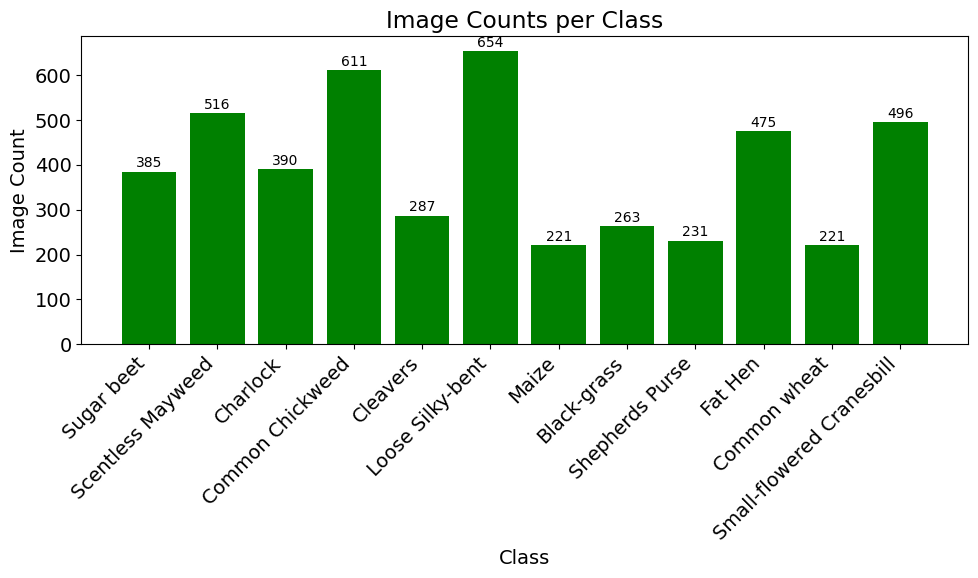

In [ ]:
import os
import matplotlib.pyplot as plt

# Directory containing subdirectories for each class
root_dir = "/content/train/"

# Get a list of subdirectories (each subdirectory corresponds to a class)
class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Create a dictionary to store the count of images for each class
class_counts = {}

# Loop through each class directory and count the images
for class_dir in class_dirs:
    class_path = os.path.join(root_dir, class_dir)
    # Get the list of files (images) in the class directory
    class_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    # Store the count in the dictionary
    class_counts[class_dir] = len(class_files)

# Extract class names and counts for plotting
class_names = list(class_counts.keys())
image_counts = list(class_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, image_counts, color='green')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.title('Image Counts per Class')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

# Annotate the counts on top of each bar
for bar, count in zip(bars, image_counts):
    plt.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

plt.tight_layout()

# Show the plot
plt.show()

Data Augmentatuion

In [ ]:
import os
import shutil
import random
from PIL import Image
from PIL import ImageEnhance
import numpy as np

# Function to apply various data augmentation techniques
def apply_data_augmentation(image):
    # Randomly rotate the image by an angle between -30 and 30 degrees
    angle = random.randint(-30, 30)
    augmented_image = image.rotate(angle)

    # Randomly flip horizontally
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_LEFT_RIGHT)

    # Randomly flip vertically
    if random.choice([True, False]):
        augmented_image = augmented_image.transpose(Image.FLIP_TOP_BOTTOM)

    # Randomly adjust brightness
    enhancer = ImageEnhance.Brightness(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly adjust contrast
    enhancer = ImageEnhance.Contrast(augmented_image)
    augmented_image = enhancer.enhance(random.uniform(0.5, 1.5))

    # Randomly crop and resize
    crop_width, crop_height = (random.randint(100, 200), random.randint(100, 200))
    augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)



    return augmented_image

# Function to oversample a specific class (subdirectory)
def oversample_subdirectory(source_dir, oversampled_dir, subdirectory_name, desired_images_for_subdirectory):
    subdirectory_path = os.path.join(source_dir, subdirectory_name)
    subdirectory_images = [f for f in os.listdir(subdirectory_path) if f.lower().endswith('.png')]

    # Calculate the number of existing images in the subdirectory
    subdirectory_count = len(subdirectory_images)

    # Calculate how many additional images are needed
    num_images_needed = desired_images_for_subdirectory - subdirectory_count

    # Make sure we don't exceed the desired count
    num_images_needed = min(num_images_needed, desired_images_for_subdirectory)

    # Create a subdirectory in the oversampled directory for the subdirectory
    oversampled_subdirectory_path = os.path.join(oversampled_dir, subdirectory_name)
    os.makedirs(oversampled_subdirectory_path, exist_ok=True)

    # Copy existing images to the oversampled directory
    for image_name in subdirectory_images:
        source_path = os.path.join(subdirectory_path, image_name)
        dest_path = os.path.join(oversampled_subdirectory_path, image_name)
        shutil.copy(source_path, dest_path)

    # Generate additional images for the subdirectory until the desired count is reached
    while num_images_needed > 0:
        # Randomly select an existing image to augment
        existing_image_name = random.choice(subdirectory_images)
        existing_image_path = os.path.join(subdirectory_path, existing_image_name)

        # Load the image using PIL
        image = Image.open(existing_image_path)

        # Apply data augmentation techniques
        augmented_image = apply_data_augmentation(image)

        # Save the augmented image
        new_image_name = f'aug_{existing_image_name}'
        new_image_path = os.path.join(oversampled_subdirectory_path, new_image_name)
        augmented_image.save(new_image_path)

        # Update the count
        num_images_needed -= 1


In [ ]:
source_dir = '/content/train'
oversampled_dir = '/content/oversampled_train'
subdirectory_to_augment = 'Black-grass'
desired_images_for_subdirectory = 654

In [ ]:
oversample_subdirectory(source_dir, oversampled_dir, subdirectory_to_augment, desired_images_for_subdirectory)

<ipython-input-6-10b7e437f3ef>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


In [ ]:
subdirectory_to_augment = 'Common wheat'
oversample_subdirectory(source_dir, oversampled_dir, subdirectory_to_augment, desired_images_for_subdirectory)

<ipython-input-6-10b7e437f3ef>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


In [ ]:
subdirectory_to_augment = 'Charlock'
oversample_subdirectory(source_dir, oversampled_dir, subdirectory_to_augment, desired_images_for_subdirectory)

<ipython-input-6-10b7e437f3ef>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


In [ ]:
subdirectory_to_augment = 'Cleavers'
oversample_subdirectory(source_dir, oversampled_dir, subdirectory_to_augment, desired_images_for_subdirectory)

<ipython-input-6-10b7e437f3ef>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


In [ ]:
subdirectory_to_augment = 'Maize'
oversample_subdirectory(source_dir, oversampled_dir, subdirectory_to_augment, desired_images_for_subdirectory)

<ipython-input-6-10b7e437f3ef>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


In [ ]:
subdirectory_to_augment = 'Sugar beet'
oversample_subdirectory(source_dir, oversampled_dir, subdirectory_to_augment, desired_images_for_subdirectory)

<ipython-input-6-10b7e437f3ef>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


In [ ]:
subdirectory_to_augment = 'Shepherds Purse'
oversample_subdirectory(source_dir, oversampled_dir, subdirectory_to_augment, desired_images_for_subdirectory)

<ipython-input-6-10b7e437f3ef>:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  augmented_image = augmented_image.resize((crop_width, crop_height), Image.ANTIALIAS)


In [ ]:
import os
import shutil

# Source directory (contains the classes you want to copy)
source_directory = '/content/train'

# Destination directory (where you want to paste the selected classes)
destination_directory = '/content/oversampled_train'

# List of classes you want to copy
classes_to_copy = [
    'Fat Hen',
    'Loose Silky-bent',
    'Small-flowered Cranesbill',
    'Common Chickweed',
    'Scentless Mayweed'
]

# Create the destination directory if it doesn't exist
os.makedirs(destination_directory, exist_ok=True)

# Loop through the classes and copy them to the destination
for class_name in classes_to_copy:
    source_class_dir = os.path.join(source_directory, class_name)
    destination_class_dir = os.path.join(destination_directory, class_name)

    # Use shutil.copytree to copy the entire class directory and its contents
    shutil.copytree(source_class_dir, destination_class_dir)




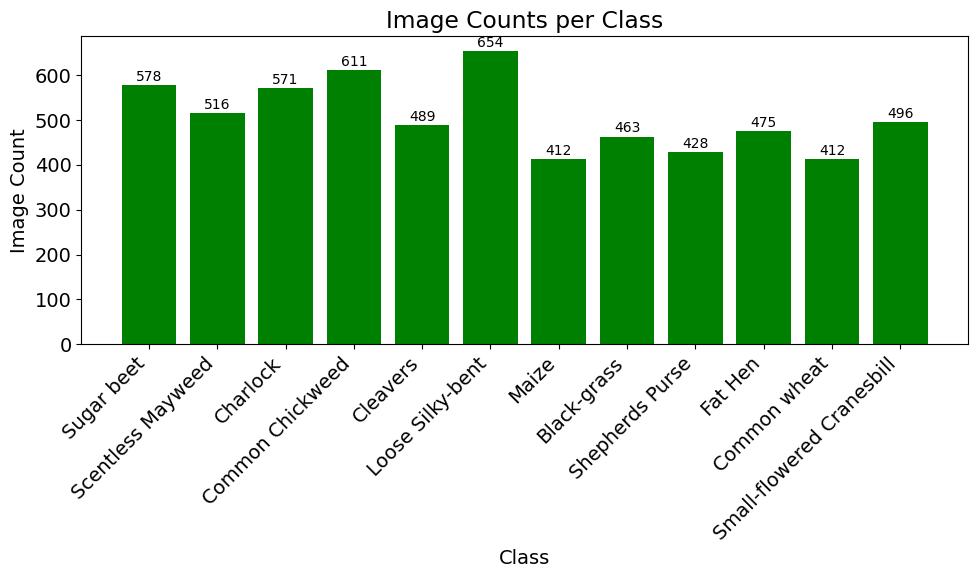

In [ ]:
import os
import matplotlib.pyplot as plt

# Directory containing subdirectories for each class
root_dir = "/content/oversampled_train"

# Get a list of subdirectories (each subdirectory corresponds to a class)
class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

# Create a dictionary to store the count of images for each class
class_counts = {}

# Loop through each class directory and count the images
for class_dir in class_dirs:
    class_path = os.path.join(root_dir, class_dir)
    # Get the list of files (images) in the class directory
    class_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    # Store the count in the dictionary
    class_counts[class_dir] = len(class_files)

# Extract class names and counts for plotting
class_names = list(class_counts.keys())
image_counts = list(class_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, image_counts, color='green')
plt.xlabel('Class')
plt.ylabel('Image Count')
plt.title('Image Counts per Class')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability

# Annotate the counts on top of each bar
for bar, count in zip(bars, image_counts):
    plt.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the batch size
batch_size = 32
img_size=224
# Directory path for oversampled data
oversampled_train_dir = '/content/oversampled_train'

# Create the data generator with rescaling
datagen = ImageDataGenerator(rescale=1/255, validation_split=0.15)

# Create the train generator with a portion of the data for validation
train_generator = datagen.flow_from_directory(
    oversampled_train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,  # You can shuffle the data for training
    subset='training'  # Specify 'training' subset for the train generator
)

# Create the validation generator with a portion of the data
val_generator = datagen.flow_from_directory(
    oversampled_train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Do not shuffle the data for validation
    subset='validation'  # Specify 'validation' subset for the validation generator
)

Found 5195 images belonging to 12 classes.
Found 910 images belonging to 12 classes.


In [ ]:
#preprocessing test images
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                              data_format='channels_last')  # Specify 'channels_last' for PNG images
test_generator = test_datagen.flow_from_directory(
    directory='/content',
    classes=['test'],
    target_size=(img_size, img_size),
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

Found 794 images belonging to 1 classes.


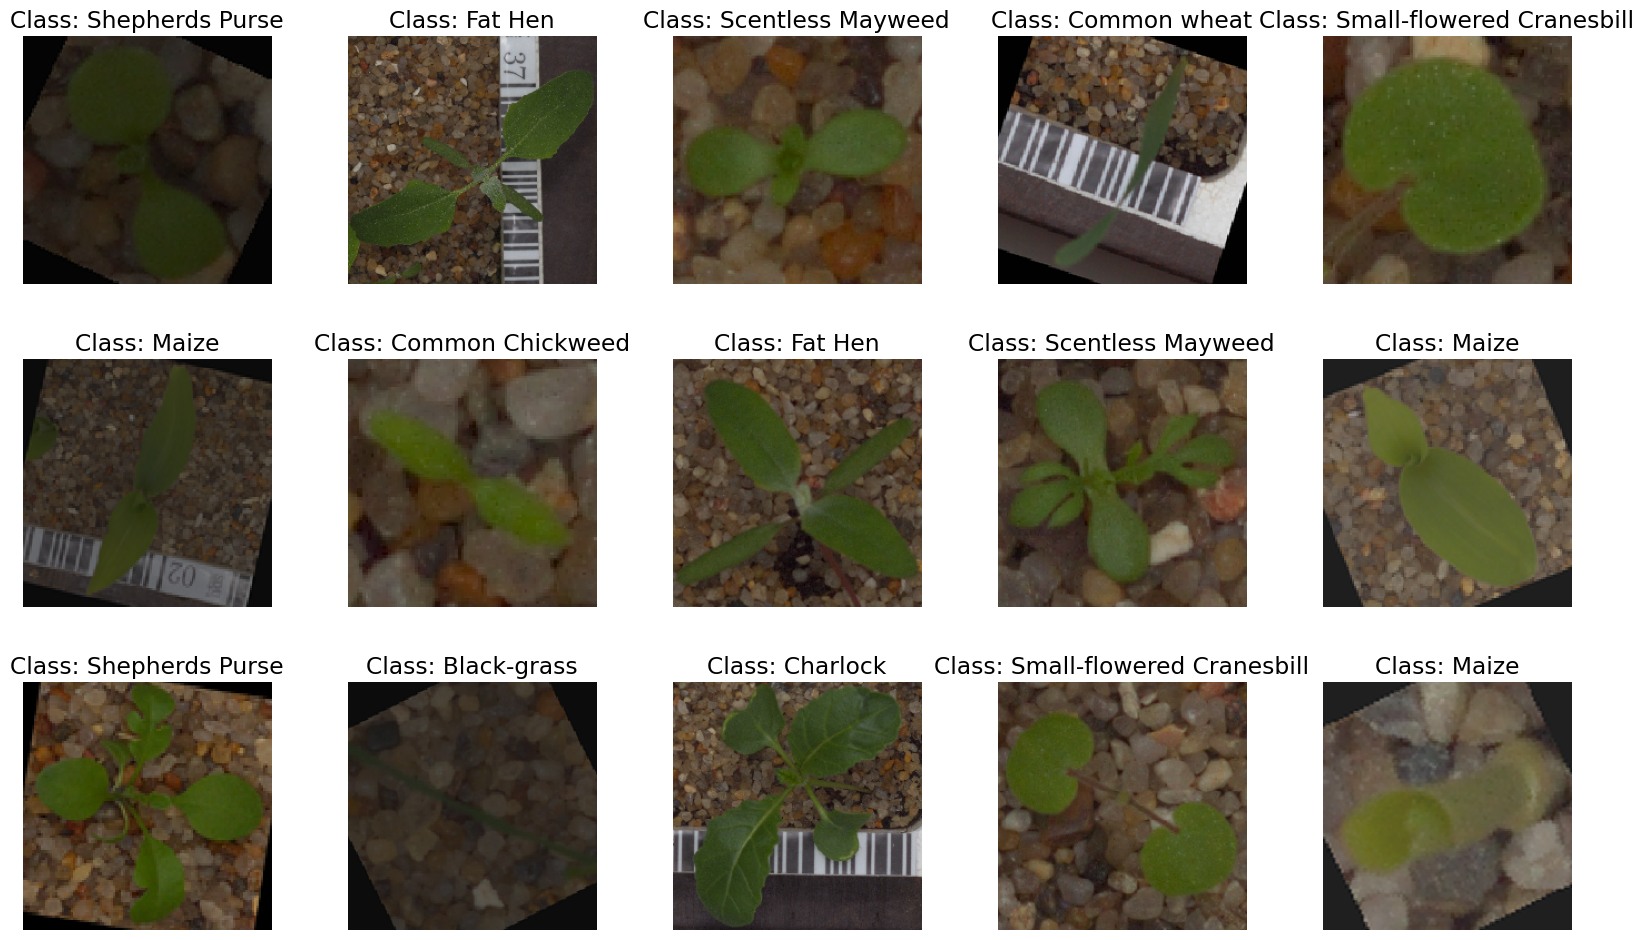

In [ ]:
#Plotting training images
label = [k for k in train_generator.class_indices]
samples = train_generator.__next__()
images = samples[0]
titles = samples[1]
plt.figure(figsize=(20,20))

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {label[np.argmax(titles[i],axis=0)]}")
    plt.axis("off")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Create VGG16 Model

In [ ]:
#create the model
base_model_1=tf.keras.applications.vgg16.VGG16(include_top=False,weights='imagenet',input_shape=(img_size,img_size,3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
base_model_1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Compile the model
last_output = base_model_1.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(12, activation='softmax')(x)
model_1 = Model(inputs=base_model_1.inputs,outputs=outputs)
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Save the modeland add callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_name = "model_vgg.h5"
Checkpoint = ModelCheckpoint(model_name,monitor="val_loss",mode="min",save_best_only=True,verbose=1)
es = EarlyStopping(monitor='val_loss',patience=7,restore_best_weights=True)
lrr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=0.00000001)

In [ ]:
#Fit the model
history = model_1.fit(train_generator,epochs=50,validation_data=val_generator,callbacks=[Checkpoint,es,lrr])

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 2.4921 - accuracy: 0.0974
Epoch 1: val_loss improved from inf to 2.47836, saving model to model_vgg.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 121s 574ms/step - loss: 2.4921 - accuracy: 0.0974 - val_loss: 2.4784 - val_accuracy: 0.1077 - lr: 1.0000e-04
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 2.4776 - accuracy: 0.1101
Epoch 2: val_loss improved from 2.47836 to 2.46187, saving model to model_vgg.h5
163/163 [==============================] - 85s 519ms/step - loss: 2.4776 - accuracy: 0.1101 - val_loss: 2.4619 - val_accuracy: 0.1275 - lr: 1.0000e-04
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 2.3481 - accuracy: 0.1646
Epoch 3: val_loss improved from 2.46187 to 1.89911, saving model to model_vgg.h5
163/163 [==============================] - 83s 507ms/step - loss: 2.3481 - accuracy: 0.1646 - val_loss: 1.8991 - val_accuracy: 0.3396 - lr: 1.0000e-04
Epoch 4/50
163/163 [==============================] - ETA: 0s - loss: 1.5822 - accuracy: 0.4073
Epoch 4: val_loss improved from 1.89911 to 1.22821, saving model to model_vgg.h5
163/163 [======

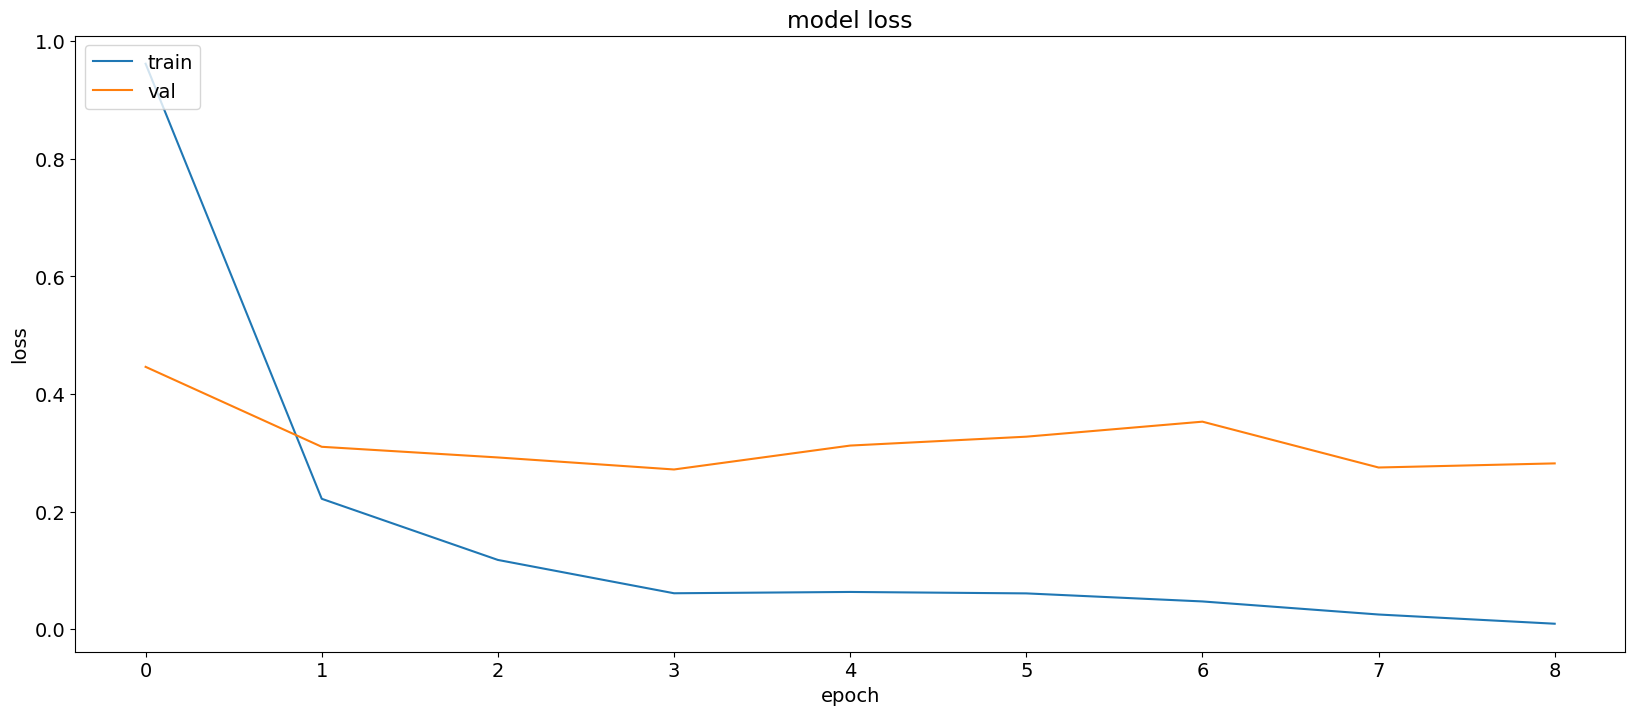

In [ ]:
#load the saved model
model = tf.keras.models.load_model("/content/model_vgg.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

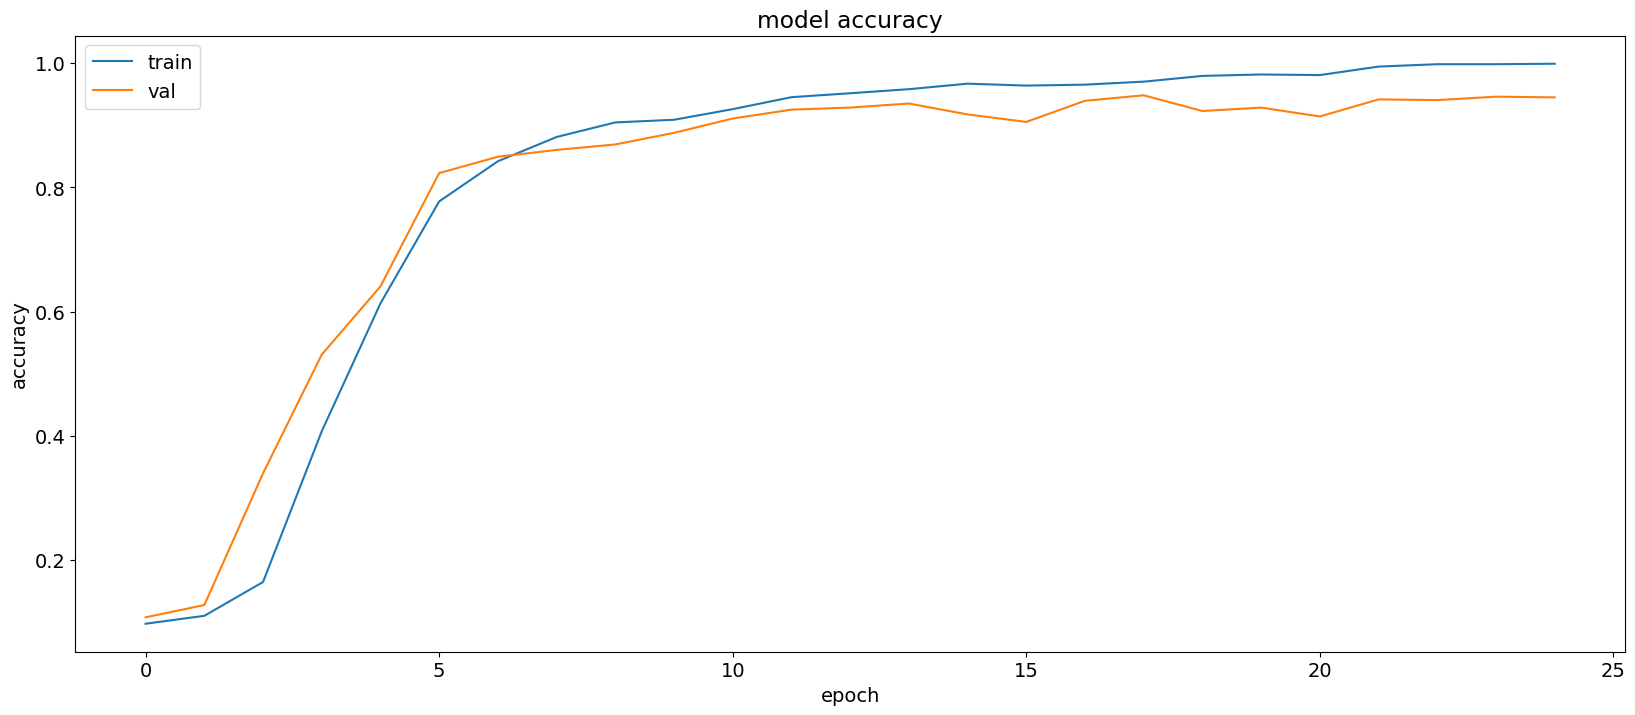

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred,axis=1)

29/29 [==============================] - 15s 469ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred,target_names = label))

                           precision    recall  f1-score   support

              Black-grass       0.86      0.70      0.77        69
                 Charlock       1.00      1.00      1.00        85
                 Cleavers       1.00      0.96      0.98        73
         Common Chickweed       0.99      0.98      0.98        91
             Common wheat       0.97      0.95      0.96        61
                  Fat Hen       0.96      0.99      0.97        71
         Loose Silky-bent       0.83      0.94      0.88        98
                    Maize       0.97      0.97      0.97        61
        Scentless Mayweed       0.91      1.00      0.95        77
          Shepherds Purse       1.00      0.92      0.96        64
Small-flowered Cranesbill       1.00      0.97      0.99        74
               Sugar beet       0.95      0.98      0.97        86

                 accuracy                           0.95       910
                macro avg       0.95      0.95      0.95    

Confusion Matrix:
[[48  0  0  0  1  0 18  1  0  0  0  1]
 [ 0 85  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 70  1  0  0  0  0  1  0  0  1]
 [ 0  0  0 89  0  0  1  0  1  0  0  0]
 [ 1  0  0  0 58  1  0  0  0  0  0  1]
 [ 0  0  0  0  0 70  0  0  0  0  0  1]
 [ 6  0  0  0  0  0 92  0  0  0  0  0]
 [ 0  0  0  0  1  0  0 59  1  0  0  0]
 [ 0  0  0  0  0  0  0  0 77  0  0  0]
 [ 0  0  0  0  0  0  0  0  5 59  0  0]
 [ 0  0  0  0  0  1  0  1  0  0 72  0]
 [ 1  0  0  0  0  1  0  0  0  0  0 84]]


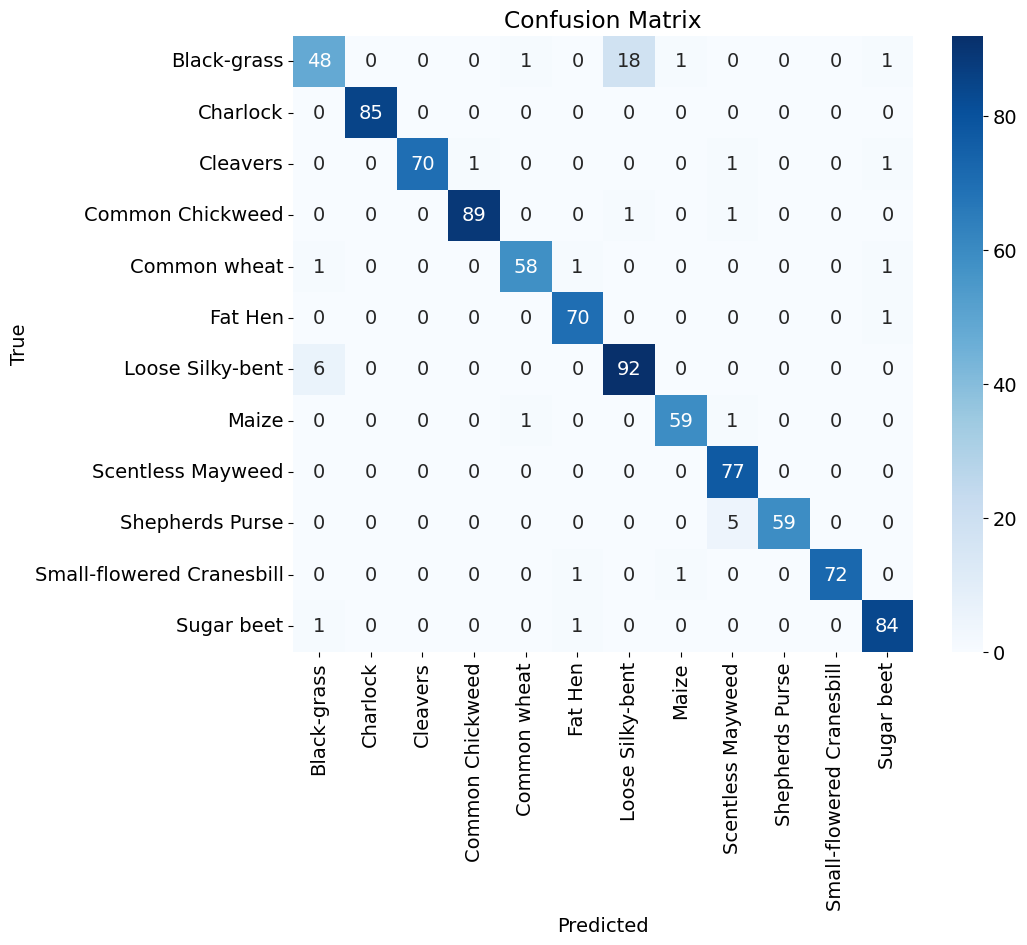

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming y_test and y_pred contain your true labels and predicted labels
# Assuming label is a list of class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can create a visual representation of the confusion matrix
# This is useful for a more intuitive understanding
import seaborn as sns
import matplotlib.pyplot as plt

# Define the labels for the confusion matrix
class_labels = label

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
preds = model.predict(test_generator, steps=test_generator.samples)

794/794 [==============================] - 9s 10ms/step


In [ ]:
class_labels = list(train_generator.class_indices)
class_labels

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [ ]:
class_list = []

for i in range(0, preds.shape[0]):
    y_class = preds[i].argmax(axis=-1)
    class_list += [class_labels[y_class]]

submission = pd.DataFrame()
submission['file'] = test_generator.filenames
submission['file'] = submission['file'].str.replace(r'test/', '')
submission['species'] = class_list

submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head(10)

,file,species
0,0021e90e4.png,Small-flowered Cranesbill
1,003d61042.png,Fat Hen
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Sugar beet
5,00d090cde.png,Loose Silky-bent
6,00ef713a8.png,Common Chickweed
7,01291174f.png,Fat Hen
8,026716f9b.png,Loose Silky-bent
9,02cfeb38d.png,Loose Silky-bent


Create A Inception model model



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
base_model_2 = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
# Freeze the first few layers
for layer in base_model_2.layers[:3]:
    layer.trainable = False

In [ ]:
# Add your custom output layers
last_output = base_model_2.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(12, activation='softmax')(x)

In [ ]:
# Create the InceptionV2-based model
model_2 = Model(inputs=base_model_2.inputs, outputs=outputs)

In [ ]:
# Compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Save the model and add callbacks
model_name = "model_inceptionv3.h5"
Checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lrr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=0.00000001)

In [ ]:
# Train the model
history = model_2.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[Checkpoint, es, lrr])

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 0.9617 - accuracy: 0.6895
Epoch 1: val_loss improved from inf to 0.44618, saving model to model_inceptionv3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 135s 533ms/step - loss: 0.9617 - accuracy: 0.6895 - val_loss: 0.4462 - val_accuracy: 0.8593 - lr: 1.0000e-04
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9272
Epoch 2: val_loss improved from 0.44618 to 0.31021, saving model to model_inceptionv3.h5
163/163 [==============================] - 75s 459ms/step - loss: 0.2218 - accuracy: 0.9272 - val_loss: 0.3102 - val_accuracy: 0.9044 - lr: 1.0000e-04
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 0.1178 - accuracy: 0.9628
Epoch 3: val_loss improved from 0.31021 to 0.29209, saving model to model_inceptionv3.h5
163/163 [==============================] - 75s 458ms/step - loss: 0.1178 - accuracy: 0.9628 - val_loss: 0.2921 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 4/50
163/163 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9806
Epoch 4: val_loss improved from 0.29209 to 0.27164, saving model to model_incept

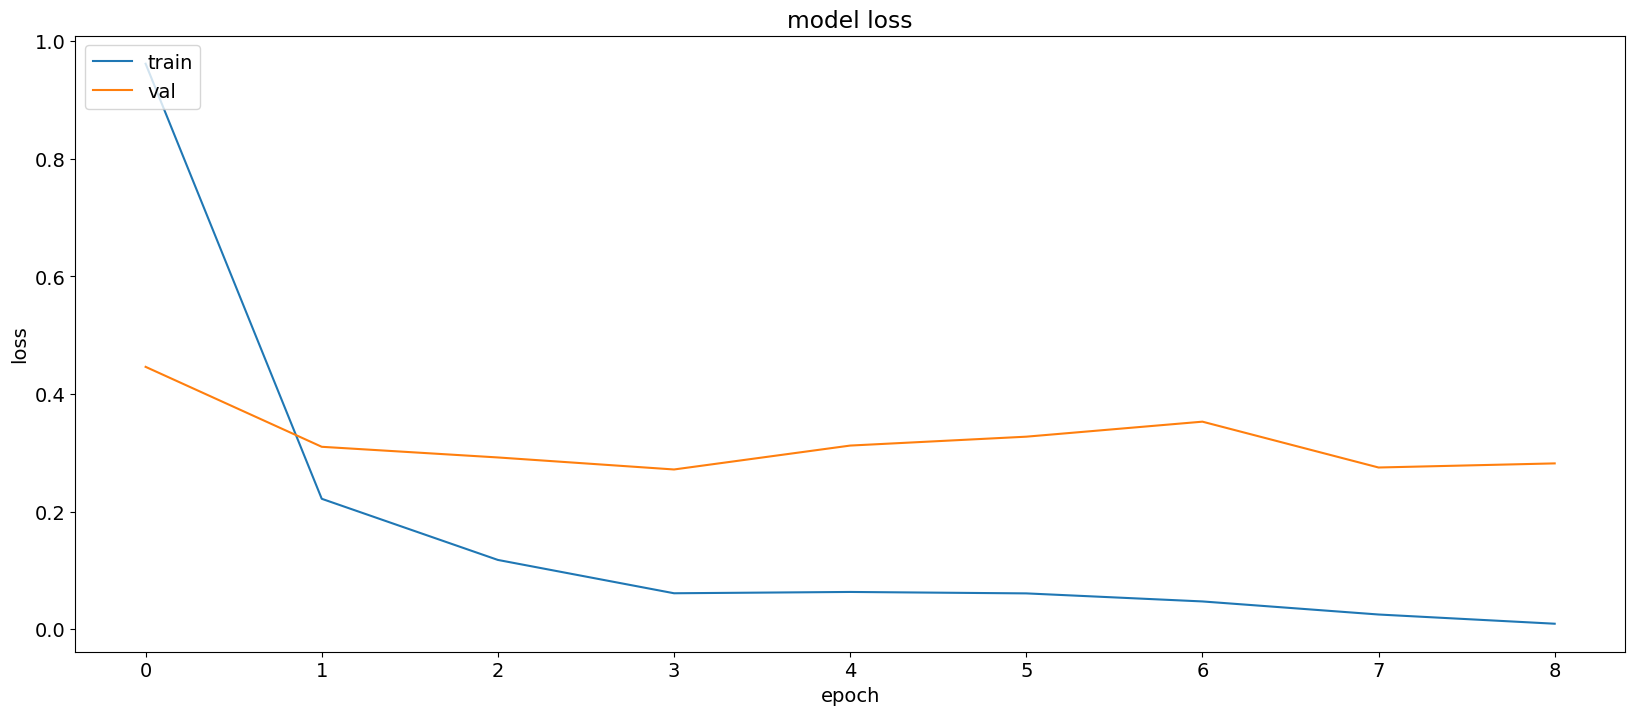

In [ ]:
#load the saved model
model = tf.keras.models.load_model("/content/model_inceptionv3.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

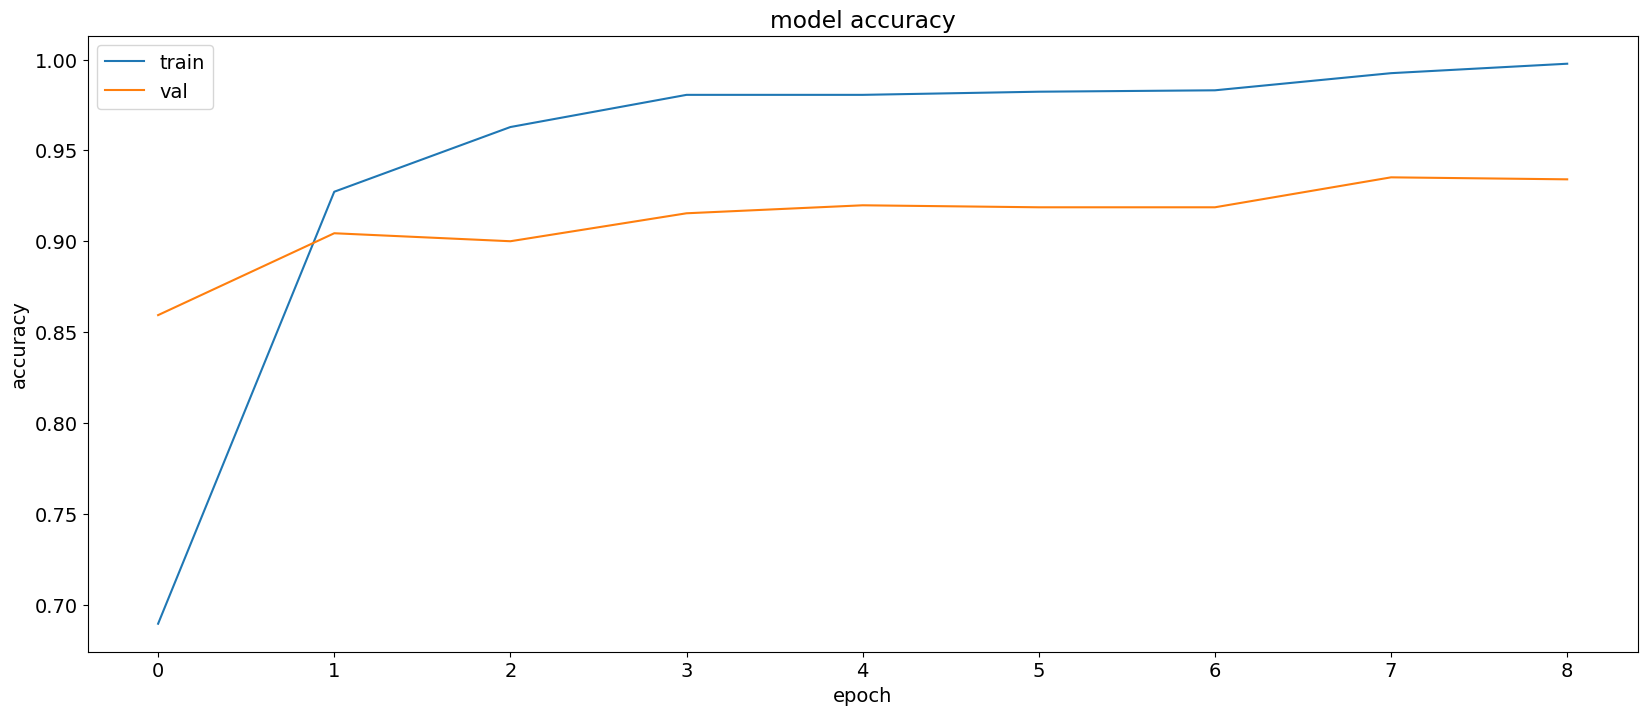

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred,axis=1)

29/29 [==============================] - 14s 405ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred,target_names = label))

                           precision    recall  f1-score   support

              Black-grass       0.72      0.48      0.57        69
                 Charlock       0.97      1.00      0.98        85
                 Cleavers       1.00      0.96      0.98        73
         Common Chickweed       0.92      0.96      0.94        91
             Common wheat       0.89      0.97      0.93        61
                  Fat Hen       0.97      0.99      0.98        71
         Loose Silky-bent       0.72      0.89      0.80        98
                    Maize       0.95      0.97      0.96        61
        Scentless Mayweed       0.96      0.94      0.95        77
          Shepherds Purse       0.95      0.92      0.94        64
Small-flowered Cranesbill       0.99      0.95      0.97        74
               Sugar beet       0.99      0.95      0.97        86

                 accuracy                           0.92       910
                macro avg       0.92      0.91      0.91    

Confusion Matrix:
[[33  0  0  0  6  0 30  0  0  0  0  0]
 [ 0 85  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 70  2  0  1  0  0  0  0  0  0]
 [ 1  0  0 87  0  0  0  0  0  3  0  0]
 [ 0  0  0  0 59  1  1  0  0  0  0  0]
 [ 0  0  0  0  0 70  1  0  0  0  0  0]
 [11  0  0  0  0  0 87  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 59  1  0  0  0]
 [ 0  0  0  5  0  0  0  0 72  0  0  0]
 [ 0  1  0  0  0  0  0  0  2 59  1  1]
 [ 0  2  0  1  1  0  0  0  0  0 70  0]
 [ 0  0  0  0  0  0  1  3  0  0  0 82]]


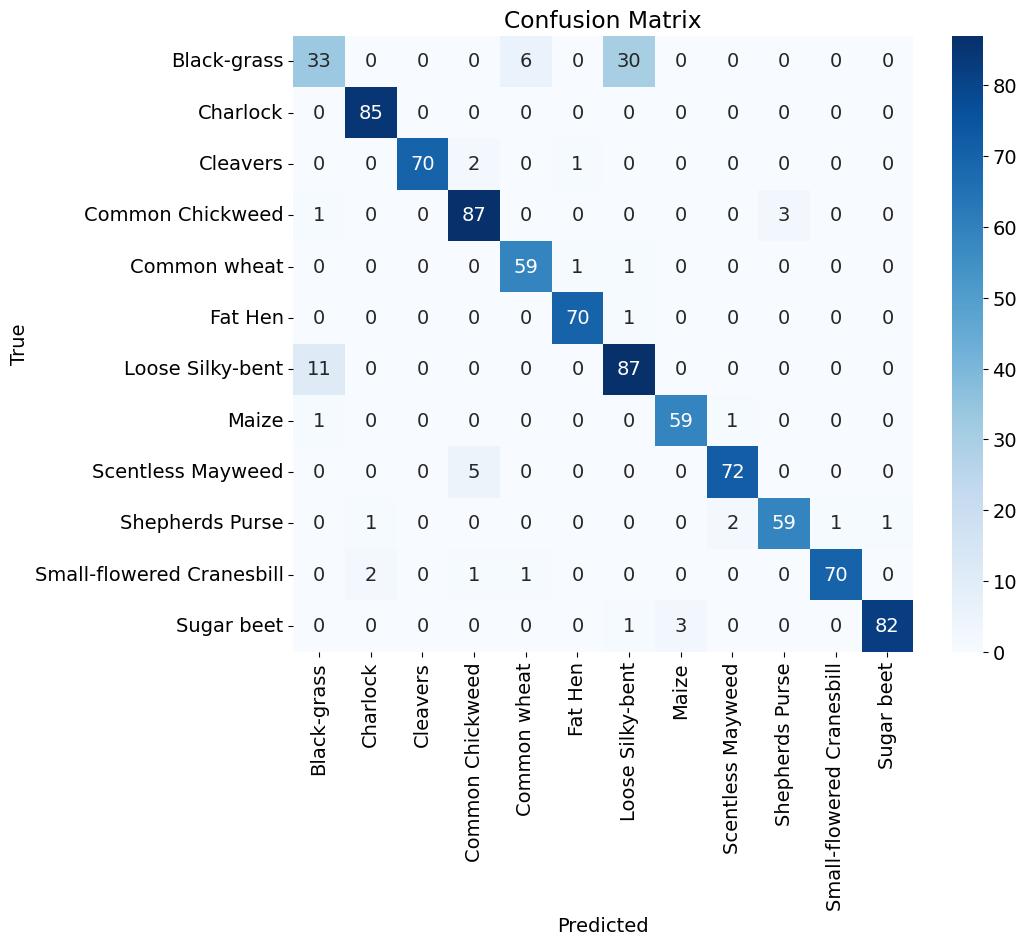

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming y_test and y_pred contain your true labels and predicted labels
# Assuming label is a list of class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can create a visual representation of the confusion matrix
# This is useful for a more intuitive understanding
import seaborn as sns
import matplotlib.pyplot as plt

# Define the labels for the confusion matrix
class_labels = label

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
preds = model.predict(test_generator, steps=test_generator.samples)

794/794 [==============================] - 16s 19ms/step


In [ ]:
class_labels = list(train_generator.class_indices)
class_labels

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [ ]:
class_list = []

for i in range(0, preds.shape[0]):
    y_class = preds[i].argmax(axis=-1)
    class_list += [class_labels[y_class]]

submission = pd.DataFrame()
submission['file'] = test_generator.filenames
submission['file'] = submission['file'].str.replace(r'test/', '')
submission['species'] = class_list

submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head(10)

,file,species
0,0021e90e4.png,Small-flowered Cranesbill
1,003d61042.png,Fat Hen
2,007b3da8b.png,Sugar beet
3,0086a6340.png,Common Chickweed
4,00c47e980.png,Sugar beet
5,00d090cde.png,Black-grass
6,00ef713a8.png,Common Chickweed
7,01291174f.png,Fat Hen
8,026716f9b.png,Loose Silky-bent
9,02cfeb38d.png,Loose Silky-bent


Create a ResNet MODEl

In [ ]:
base_model_3 = ResNet50(include_top=False, weights='imagenet', input_shape=(img_size,img_size,3))

In [ ]:
base_model_3.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
# Freeze some initial layers if needed
for layer in base_model_3.layers[:20]:
    layer.trainable = False
base_model_3.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
# Create the custom top layers for your new model
x = GlobalAveragePooling2D()(base_model_3.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(12, activation='softmax')(x)

# Create the new model by specifying input and output layers
model_9= Model(inputs=base_model_3.inputs, outputs=outputs)

# Compile the model
model_9.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
#Save the modeland add callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_name = "model_resnet_10.h5"
Checkpoint = ModelCheckpoint(model_name,monitor="val_loss",mode="min",save_best_only=True,verbose=1)
es = EarlyStopping(monitor='val_loss',patience=7,restore_best_weights=True,mode='min')
lrr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5, min_lr=0.00000001)

In [ ]:
#fit the model
history = model_9.fit(train_generator,epochs=50,validation_data=val_generator,
                    callbacks=[Checkpoint,es,lrr])

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 1.5938 - accuracy: 0.4558
Epoch 1: val_loss improved from inf to 5.96342, saving model to model_resnet_10.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 168s 524ms/step - loss: 1.5938 - accuracy: 0.4558 - val_loss: 5.9634 - val_accuracy: 0.0681 - lr: 1.0000e-04
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.7761
Epoch 2: val_loss improved from 5.96342 to 3.67931, saving model to model_resnet_10.h5
163/163 [==============================] - 84s 511ms/step - loss: 0.6658 - accuracy: 0.7761 - val_loss: 3.6793 - val_accuracy: 0.1582 - lr: 1.0000e-04
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 0.4405 - accuracy: 0.8541
Epoch 3: val_loss improved from 3.67931 to 1.35052, saving model to model_resnet_10.h5
163/163 [==============================] - 83s 510ms/step - loss: 0.4405 - accuracy: 0.8541 - val_loss: 1.3505 - val_accuracy: 0.5879 - lr: 1.0000e-04
Epoch 4/50
163/163 [==============================] - ETA: 0s - loss: 0.3079 - accuracy: 0.8951
Epoch 4: val_loss improved from 1.35052 to 0.56423, saving model to model_resnet_10.

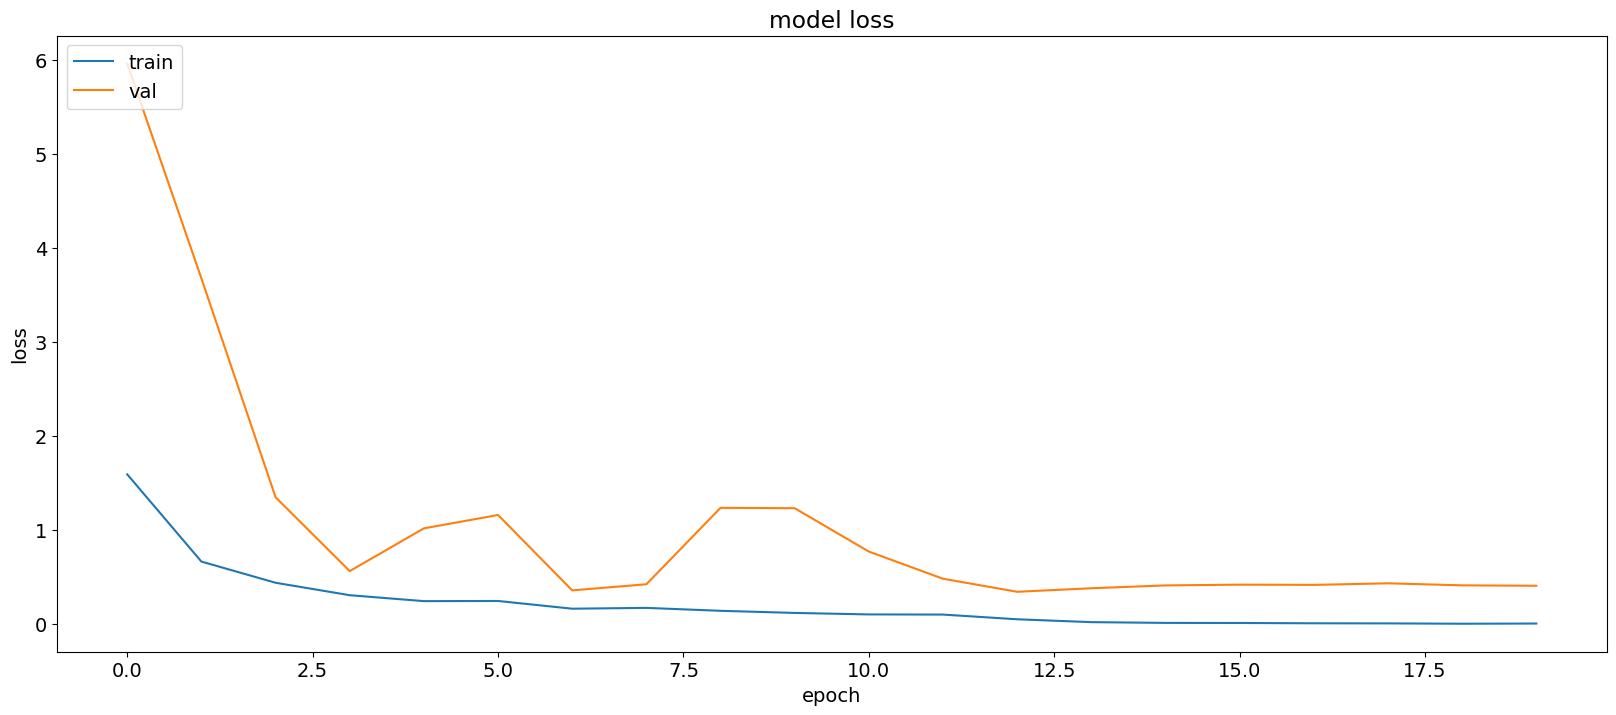

In [ ]:
#load the saved model
model = tf.keras.models.load_model("/content/model_resnet_10.h5")
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

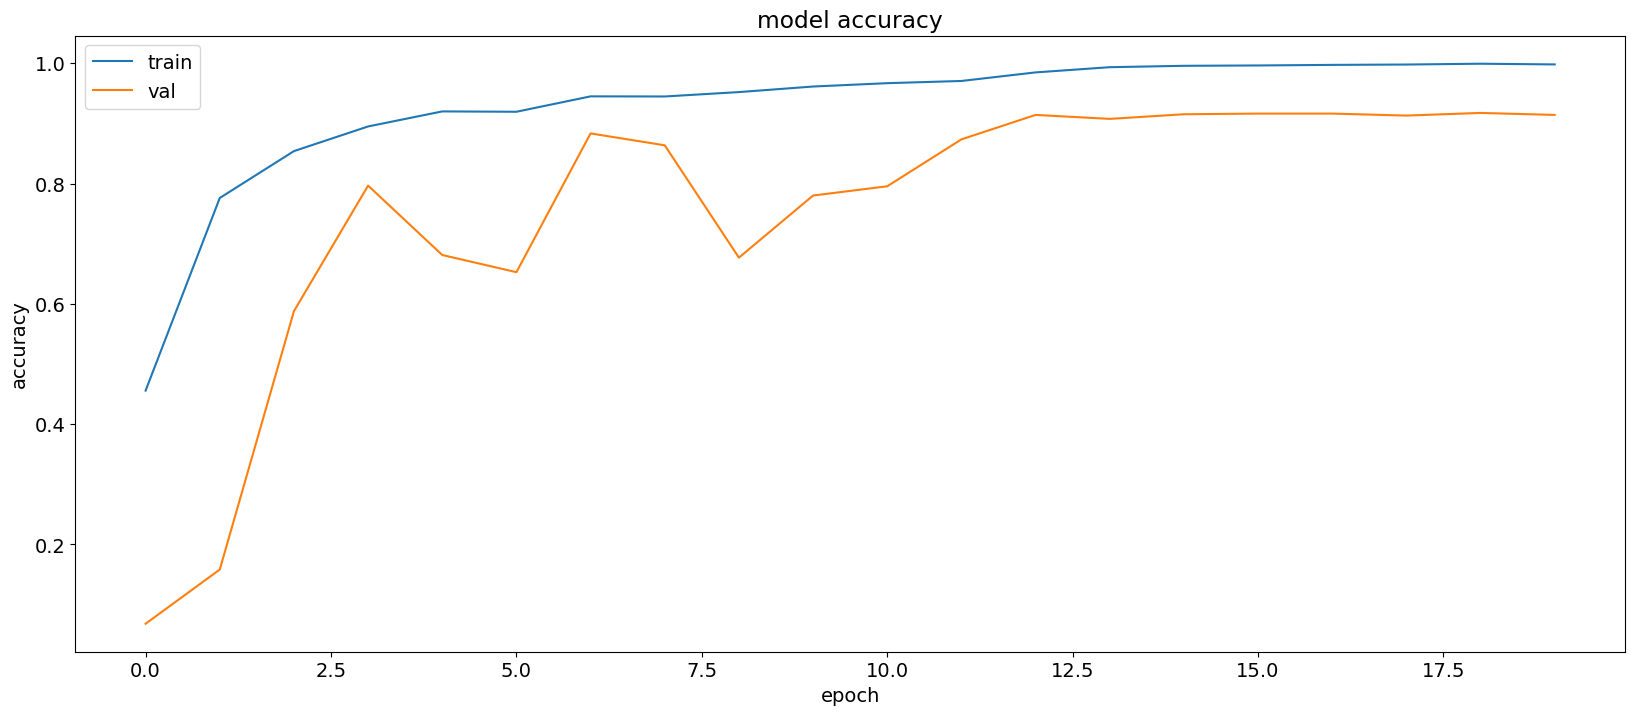

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_test = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = np.argmax(y_pred,axis=1)

29/29 [==============================] - 14s 418ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,y_pred,target_names = label))

                           precision    recall  f1-score   support

              Black-grass       0.73      0.59      0.66        69
                 Charlock       0.99      0.98      0.98        85
                 Cleavers       0.95      0.96      0.95        73
         Common Chickweed       0.96      0.93      0.94        91
             Common wheat       1.00      0.93      0.97        61
                  Fat Hen       0.97      0.92      0.94        71
         Loose Silky-bent       0.73      0.87      0.79        98
                    Maize       0.95      0.93      0.94        61
        Scentless Mayweed       0.91      1.00      0.95        77
          Shepherds Purse       1.00      0.94      0.97        64
Small-flowered Cranesbill       0.99      0.96      0.97        74
               Sugar beet       0.91      0.94      0.93        86

                 accuracy                           0.91       910
                macro avg       0.92      0.91      0.92    

Confusion Matrix:
[[41  0  0  0  0  0 28  0  0  0  0  0]
 [ 0 83  2  0  0  0  0  0  0  0  0  0]
 [ 0  0 70  1  0  0  0  0  1  0  0  1]
 [ 1  0  0 85  0  1  0  0  3  0  1  0]
 [ 1  0  0  0 57  0  2  0  0  0  0  1]
 [ 0  1  0  1  0 65  0  0  0  0  0  4]
 [12  0  0  0  0  0 85  0  1  0  0  0]
 [ 0  0  0  0  0  0  1 57  1  0  0  2]
 [ 0  0  0  0  0  0  0  0 77  0  0  0]
 [ 0  0  0  2  0  0  0  0  2 60  0  0]
 [ 0  0  2  0  0  0  1  0  0  0 71  0]
 [ 1  0  0  0  0  1  0  3  0  0  0 81]]


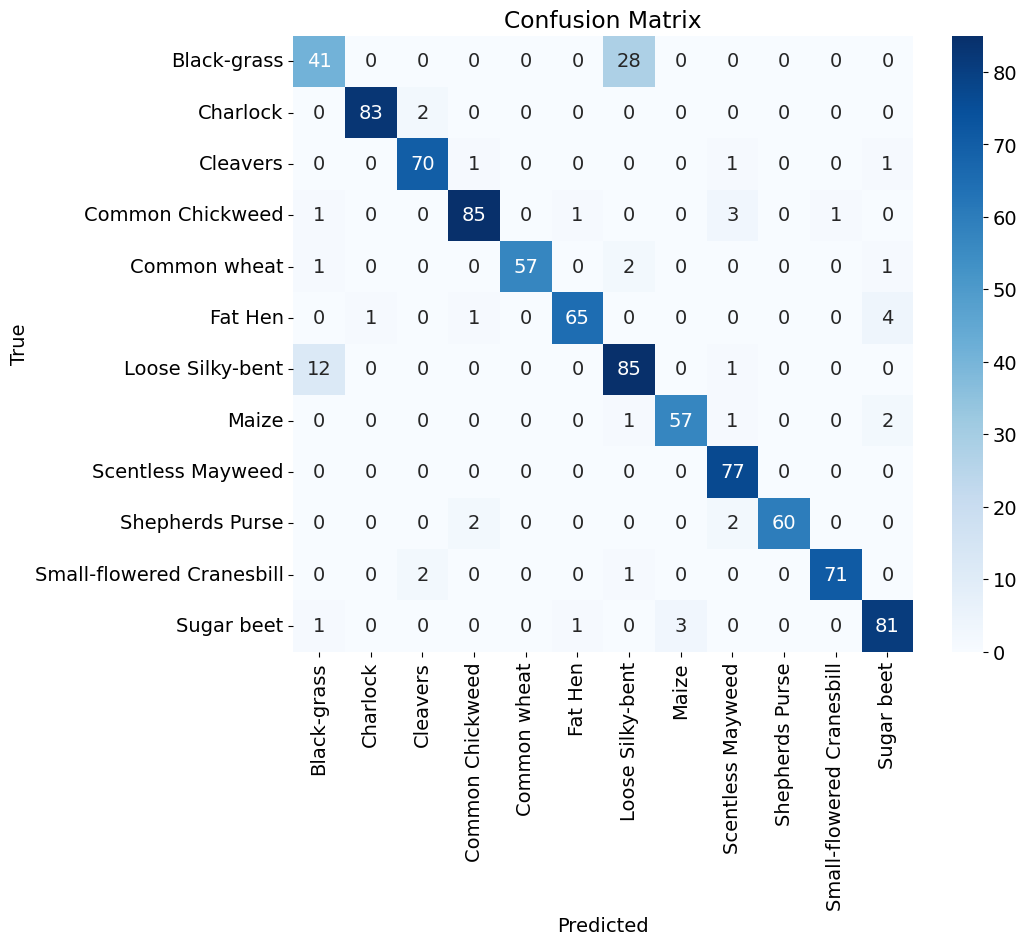

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming y_test and y_pred contain your true labels and predicted labels
# Assuming label is a list of class labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can create a visual representation of the confusion matrix
# This is useful for a more intuitive understanding
import seaborn as sns
import matplotlib.pyplot as plt

# Define the labels for the confusion matrix
class_labels = label

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()